## Imports

In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset

from ghost_unfairness.utils import *


## Constants

Remeber that after the data is processed, all privileged class values are mapped to 1 and all unprivileged class values are mapped to 0. That means in the following case, after the processing, "Male" will be mapped to 1 and "Female" will be mapped to 0.

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]


privileged_groups = [{key:1 for key in protected}]
unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

## Fair Dataset

In [4]:
fd_train = FairDataset(10000, 5, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=random_state)
fd_test = FairDataset(5000, 5,
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']])

In [5]:
fd_train_x, fd_train_y = fd_train.get_xy(keep_protected = False)
fd_test_x, fd_test_y = fd_test.get_xy(keep_protected = False)

In [6]:
fd_train

               instance weights   features                                  \
                                                                             
                                         0          1          2         3   
instance names                                                               
0                           1.0  -4.240047   6.529532   4.621040  3.202059   
1                           1.0   8.988804  -5.063934   4.118117 -1.473252   
2                           1.0  -6.968635   5.520898  -4.661701 -4.715782   
3                           1.0   3.974791   3.597666   0.438311 -6.613742   
4                           1.0  -9.173976   1.637482   2.381186  0.842143   
...                         ...        ...        ...        ...       ...   
39995                       1.0  10.583211   2.715700   5.781155  6.426265   
39996                       1.0  -0.332145   5.611537   6.965495  8.296706   
39997                       1.0   2.267198   8.159720  13.975586

In [7]:
fd_test

               instance weights   features                                  \
                                                                             
                                         0          1          2         3   
instance names                                                               
0                           1.0  -0.910376  13.189383   1.720002 -4.322470   
1                           1.0   4.340222  -1.720700   4.899498 -1.462882   
2                           1.0   3.260850   7.098223   4.824980 -5.651467   
3                           1.0   1.707329  -0.958097  -1.391007 -1.673692   
4                           1.0 -15.214695  -1.607940   4.807239  3.931088   
...                         ...        ...        ...        ...       ...   
19995                       1.0  -0.315273   2.603109  -3.096171  3.177837   
19996                       1.0   5.807729  -5.205543   3.018206  5.729951   
19997                       1.0  14.756352   9.924660  14.393051

In [8]:
get_dataset_metrics(fd_train,
                    unprivileged_groups,
                    privileged_groups, 
                    verbose=True)

Mean Difference: 0.0
Dataset Base Rate 0.5
Privileged Base Rate 0.5
Protected Base Rate 0.5
Disparate Impact: 1.0


(0.0, 1.0)

### Training Logistic Regression

In [9]:
lmod = LogisticRegression(class_weight='balanced', 
                          solver='liblinear',
                         verbose=2)
lmod.fit(fd_train_x, fd_train_y)

[LibLinear]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

In [10]:
get_classifier_metrics(lmod, fd_test,
                       privileged_groups, 
                       unprivileged_groups, 
                       verbose=True)

Mean Difference: 0.009799999999999975
Disparate Impact: 0.019483101391650104
Accuracy: 0.8742


(-0.009799999999999975, 0.9805168986083499, 0.8742)

### Training Decision Tree

In [11]:
dmod = DecisionTreeClassifier(criterion='entropy', 
                                   max_depth=40,
                                  random_state=47)
dmod = dmod.fit(fd_train_x, fd_train_y)

get_classifier_metrics(dmod, fd_test, 
                       privileged_groups, 
                       unprivileged_groups, 
                       verbose=True)

print('Tree Depth:', dmod.get_depth())

Mean Difference: 0.0015000000000000013
Disparate Impact: 0.003016894609814913
Accuracy: 0.80565
Tree Depth: 37


### Variation of fairness with model complexity

In [12]:
def train_model_variants(model_type, fd, variant, values,
                        params):
    fd_x, fd_y = fd.get_xy(keep_protected=False)
    models = []
    for val in values:
        model = model_type()
        params[variant] = val
        model.set_params(**params)

        model = model.fit(fd_x, fd_y)
        models.append(model)
        
    return models

In [13]:
def get_model_results(model, train_fd, test_fd, func=None):
    if func:
        model_property = func(model)
    else:
        model_property = None
    
    md, di, ac = get_classifier_metrics(model, train_fd,
                                        privileged_groups, 
                                        unprivileged_groups, 
                                        verbose=True)
    train_result = (md, di, ac, model_property)
    
    print('Test')
    
    md, di, ac = get_classifier_metrics(model, test_fd,
                                        privileged_groups, 
                                        unprivileged_groups,
                                       verbose=True)
    test_result = (md, di, ac, model_property)
    
    return train_result, test_result

In [14]:
def get_results(models, train_fd, test_fd, func=None):
    train_results = []
    test_results = []
    for model in models:
        train_result, test_result = get_model_results(model, train_fd, 
                                                      test_fd, func)
        train_results.append(train_result)
        test_results.append(test_result)
        
    return train_results, test_results

In [15]:
def decision_tree_property(model):
    return {'depth': model.get_depth()}

In [16]:
max_depths = [3, 5, 10, 15, 20, 25]

params = {'criterion':'entropy',
          'random_state': 47}
variant = 'max_depth'
dmods = train_model_variants(DecisionTreeClassifier,
                            fd_train, variant, max_depths,
                            params)

train_results, test_results = get_results(dmods, fd_train, fd_test,
                                         decision_tree_property)


Mean Difference: 0.0016499999999999848
Disparate Impact: 0.0036363636363635488
Accuracy: 0.776475
Test
Mean Difference: 0.0040999999999999925
Disparate Impact: 0.008985316677624366
Accuracy: 0.77025
Mean Difference: 0.0011499999999999844
Disparate Impact: 0.0023169134683187487
Accuracy: 0.829675
Test
Mean Difference: 0.007299999999999973
Disparate Impact: 0.014594162335065941
Accuracy: 0.82485
Mean Difference: 0.0025499999999999967
Disparate Impact: 0.0051045941347211965
Accuracy: 0.882825
Test
Mean Difference: 0.0047000000000000375
Disparate Impact: 0.009411293552262778
Accuracy: 0.84645
Mean Difference: 0.0008500000000000174
Disparate Impact: 0.001703748246141501
Accuracy: 0.952125
Test
Mean Difference: 0.003500000000000003
Disparate Impact: 0.007040836853751786
Accuracy: 0.81995
Mean Difference: 0.0011500000000000399
Disparate Impact: 0.0023006902070622504
Accuracy: 0.989075
Test
Mean Difference: 0.005200000000000038
Disparate Impact: 0.010556232237109331
Accuracy: 0.8082
Mean Diffe

In [17]:
train_results

[(-0.0016499999999999848, 0.9963636363636365, 0.776475, {'depth': 3}),
 (0.0011499999999999844, 1.0023169134683187, 0.829675, {'depth': 5}),
 (-0.0025499999999999967, 0.9948954058652788, 0.882825, {'depth': 10}),
 (-0.0008500000000000174, 0.9982962517538585, 0.952125, {'depth': 15}),
 (-0.0011500000000000399, 0.9976993097929377, 0.989075, {'depth': 20}),
 (0.00030000000000002247, 1.000600420294206, 0.9984, {'depth': 25})]

In [18]:
test_results

[(-0.0040999999999999925, 0.9910146833223756, 0.77025, {'depth': 3}),
 (-0.007299999999999973, 0.9854058376649341, 0.82485, {'depth': 5}),
 (-0.0047000000000000375, 0.9905887064477372, 0.84645, {'depth': 10}),
 (-0.003500000000000003, 0.9929591631462482, 0.81995, {'depth': 15}),
 (0.005200000000000038, 1.0105562322371093, 0.8082, {'depth': 20}),
 (-0.003100000000000047, 0.9938074310827006, 0.80635, {'depth': 25})]

Increasing model complexity tends to increase the disparate impact and mean difference at some point.

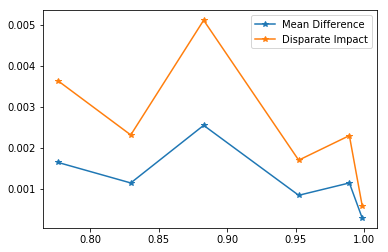

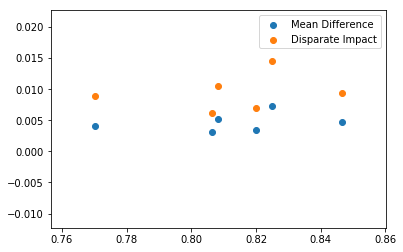

In [19]:
def plot_acc_vs_metric(results, plot_type='line'):
    mds = [abs(tup[0]) for tup in results]
    dis = [abs(1 - tup[1]) for tup in results]
    acs = [tup[2] for tup in results]
    tds = [tup[3] for tup in results]
    
    if plot_type == 'line':
        plt.plot(acs, mds, '*-', label='Mean Difference')
        plt.plot(acs, dis, '*-', label='Disparate Impact')
    elif plot_type == 'scatter':
        plt.scatter(acs, mds, label='Mean Difference')
        plt.scatter(acs, dis, label='Disparate Impact')        
    plt.legend()
    
plot_acc_vs_metric(train_results)
plt.show()
plot_acc_vs_metric(test_results, 'scatter')
plt.show()

Same characteristic can also be seen in the test dataset as well. Trying to increase accuracy in the test dataset also increases the disparate impact and mean difference.

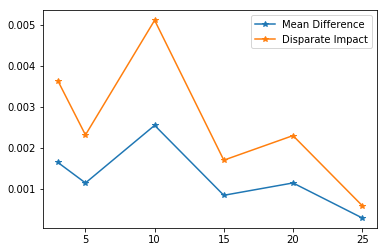

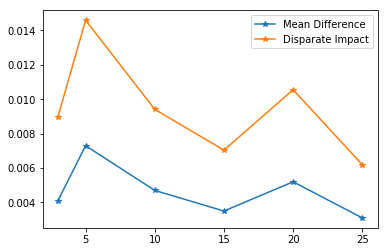

In [20]:
def plot_complexity_vs_metric(results, params):
    mds = [abs(tup[0]) for tup in results]
    dis = [abs(1-tup[1]) for tup in results]
    acs = [tup[2] for tup in results]
    tds = [tup[3] for tup in results]

    plt.plot(params, mds, '*-', label='Mean Difference')
    plt.plot(params, dis, '*-', label='Disparate Impact')
    plt.legend()
    
    
plot_complexity_vs_metric(train_results, max_depths)
plt.show()
plot_complexity_vs_metric(test_results, max_depths)

We want to see group wise accuracy rates for the models.

In [21]:
def get_group_accuracy(model, train_fd):
    train_fd_p = train_fd.get_privileged_group()
    train_fd_u = train_fd.get_unprivileged_group()
    
    _, _, acc_u = get_classifier_metrics(model, train_fd_p,
                        privileged_groups=privileged_groups,
                        unprivileged_groups=unprivileged_groups)
    
    _, _, acc_p = get_classifier_metrics(model, train_fd_u,
                        privileged_groups=privileged_groups,
                        unprivileged_groups=unprivileged_groups)
    return acc_p, acc_u

In [22]:
def get_accuracy_differences(models, train_fd):
    acc_diffs = []
    for model in models:
        acc_p, acc_u = get_group_accuracy(model, train_fd)
        acc_diffs.append(acc_p - acc_u)
        
    return acc_diffs

In [23]:
%%capture --no-stdout
acc_diffs = get_accuracy_differences(dmods, fd_train)
print(acc_diffs)

[-0.005249999999999977, -0.0008499999999999064, -0.00275000000000003, -0.0010499999999999954, -0.0008500000000000174, 9.999999999998899e-05]


#### The accuracy difference between privileged and unprivileged groups on the training dataset shows similar trend to the training dataset disparate impact.

Therefore, we want to claim that while training, one group is picked over the other as a winner even though they have same ratio of positive and negative samples.

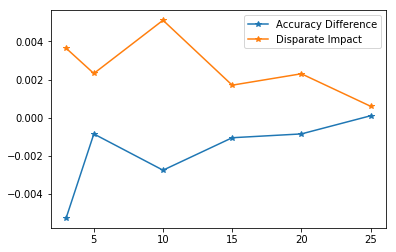

[(-0.0016499999999999848, 0.9963636363636365, 0.776475, {'depth': 3}), (0.0011499999999999844, 1.0023169134683187, 0.829675, {'depth': 5}), (-0.0025499999999999967, 0.9948954058652788, 0.882825, {'depth': 10}), (-0.0008500000000000174, 0.9982962517538585, 0.952125, {'depth': 15}), (-0.0011500000000000399, 0.9976993097929377, 0.989075, {'depth': 20}), (0.00030000000000002247, 1.000600420294206, 0.9984, {'depth': 25})]
[-0.005249999999999977, -0.0008499999999999064, -0.00275000000000003, -0.0010499999999999954, -0.0008500000000000174, 9.999999999998899e-05]


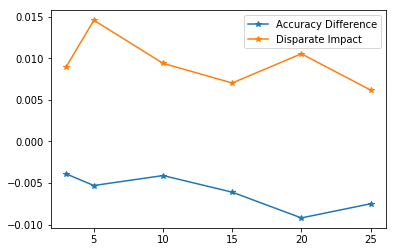

[(-0.0040999999999999925, 0.9910146833223756, 0.77025, {'depth': 3}), (-0.007299999999999973, 0.9854058376649341, 0.82485, {'depth': 5}), (-0.0047000000000000375, 0.9905887064477372, 0.84645, {'depth': 10}), (-0.003500000000000003, 0.9929591631462482, 0.81995, {'depth': 15}), (0.005200000000000038, 1.0105562322371093, 0.8082, {'depth': 20}), (-0.003100000000000047, 0.9938074310827006, 0.80635, {'depth': 25})]
[-0.0039000000000000146, -0.005299999999999971, -0.0040999999999999925, -0.006099999999999994, -0.009199999999999986, -0.007500000000000062]


In [24]:
%%capture --no-stdout --no-display
def plot_accuracy_diffrences(results, acc_diffs, values):
    dis = [abs(1 - tup[1]) for tup in results] 
    plt.plot(values, acc_diffs, '*-', label='Accuracy Difference')
    plt.plot(values, dis, '*-', label='Disparate Impact')
    plt.legend()
    
acc_diffs = get_accuracy_differences(dmods, fd_train)
plot_accuracy_diffrences(train_results, acc_diffs, max_depths)
plt.show()
print(train_results)
print(acc_diffs)
acc_diffs = get_accuracy_differences(dmods, fd_test)
plot_accuracy_diffrences(test_results, acc_diffs, max_depths)
plt.show()
print(test_results)
print(acc_diffs)

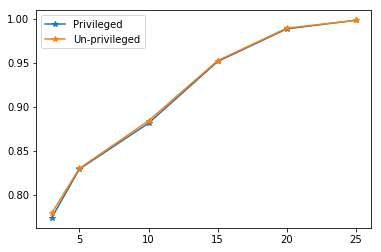

In [25]:
%%capture --no-stdout --no-display
group_accs = [get_group_accuracy(model, fd_train) for model in dmods]
acs_p = [tup[0] for tup in group_accs]
acs_u = [tup[1] for tup in group_accs]
plt.plot(max_depths, acs_p, '*-', label='Privileged')
plt.plot(max_depths, acs_u, '*-', label='Un-privileged')
plt.legend()

### Training with reqularization parameter

In [26]:
def logistic_reg_property(model):
    # TODO: will return theta from this function.
    return {}

In [27]:
regularizers = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

params = {'class_weight': 'balanced',
          'solver': 'liblinear'}
variant = 'C'
lmods = train_model_variants(LogisticRegression,
                            fd_train, variant, regularizers,
                            params)

lr_train_results, lr_test_results = get_results(lmods, fd_train, fd_test,
                                                logistic_reg_property)


Mean Difference: 0.0016000000000000458
Disparate Impact: 0.002201582387340917
Accuracy: 0.7584
Test
Mean Difference: 0.006599999999999939
Disparate Impact: 0.009051014810751434
Accuracy: 0.7605
Mean Difference: 0.0019500000000000073
Disparate Impact: 0.0030090270812437314
Accuracy: 0.815875
Test
Mean Difference: 0.006099999999999994
Disparate Impact: 0.009370199692780301
Accuracy: 0.82045
Mean Difference: 0.0030000000000000027
Disparate Impact: 0.005523844595838656
Accuracy: 0.86345
Test
Mean Difference: 0.0026999999999999247
Disparate Impact: 0.004985228951255416
Accuracy: 0.86905
Mean Difference: 0.003049999999999997
Disparate Impact: 0.005996854109319716
Accuracy: 0.869025
Test
Mean Difference: 0.009000000000000008
Disparate Impact: 0.017664376840039298
Accuracy: 0.8746
Mean Difference: 0.0030000000000000027
Disparate Impact: 0.005960659646334188
Accuracy: 0.8697
Test
Mean Difference: 0.009700000000000042
Disparate Impact: 0.019257494540401154
Accuracy: 0.87425
Mean Difference: 0.00

In [28]:
print(lr_train_results)
lr_test_results

[(0.0016000000000000458, 1.002201582387341, 0.7584, {}), (0.0019500000000000073, 1.0030090270812437, 0.815875, {}), (-0.0030000000000000027, 0.9944761554041613, 0.86345, {}), (-0.003049999999999997, 0.9940031458906803, 0.869025, {}), (-0.0030000000000000027, 0.9940393403536658, 0.8697, {}), (-0.002900000000000069, 0.9942300039793075, 0.8697, {}), (-0.00269999999999998, 0.9946252612720216, 0.86985, {}), (-0.00269999999999998, 0.9946252612720216, 0.86985, {})]


[(-0.006599999999999939, 0.9909489851892486, 0.7605, {}),
 (-0.006099999999999994, 0.9906298003072197, 0.82045, {}),
 (-0.0026999999999999247, 0.9950147710487446, 0.86905, {}),
 (-0.009000000000000008, 0.9823356231599607, 0.8746, {}),
 (-0.009700000000000042, 0.9807425054595988, 0.87425, {}),
 (-0.009799999999999975, 0.9805168986083499, 0.8742, {}),
 (-0.009699999999999986, 0.9807118711473454, 0.87425, {}),
 (-0.009699999999999986, 0.9807118711473454, 0.87425, {})]

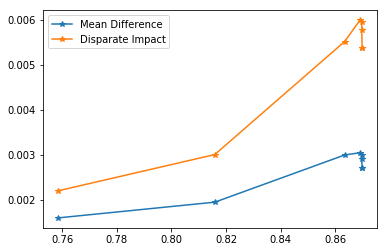

In [29]:
plot_acc_vs_metric(lr_train_results)

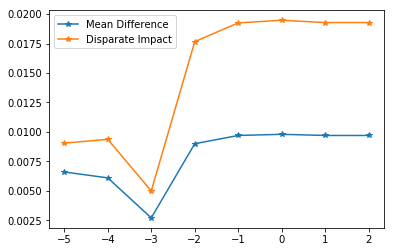

In [30]:
plot_complexity_vs_metric(lr_test_results, np.log10(regularizers))

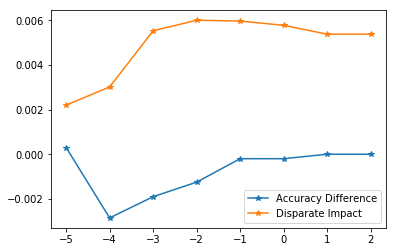

In [31]:
%%capture --no-stdout --no-display
acc_diffs = get_accuracy_differences(lmods, fd_train)
plot_accuracy_diffrences(lr_train_results, acc_diffs, np.log10(regularizers))

In [32]:
acc_diffs

[0.00029999999999996696,
 -0.002850000000000019,
 -0.0018999999999999018,
 -0.0012500000000000844,
 -0.00019999999999997797,
 -0.00019999999999997797,
 0.0,
 0.0]

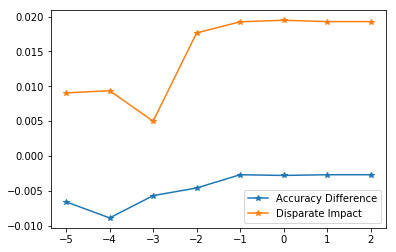

In [33]:
%%capture --no-stdout --no-display
acc_diffs = get_accuracy_differences(lmods, fd_test)
plot_accuracy_diffrences(lr_test_results, acc_diffs, np.log10(regularizers))

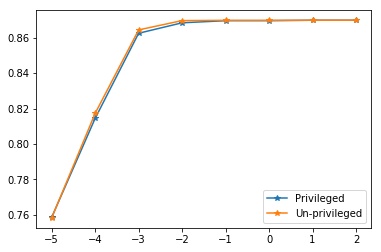

In [34]:
%%capture --no-stdout --no-display
group_accs = [get_group_accuracy(model, fd_train) for model in lmods]
acs_p = [tup[0] for tup in group_accs]
acs_u = [tup[1] for tup in group_accs]
plt.plot(np.log10(regularizers), acs_p, '*-', label='Privileged')
plt.plot(np.log10(regularizers), acs_u, '*-', label='Un-privileged')
plt.legend()

Does test measures average out?

[[0.0145     0.01954943 0.75325   ]
 [0.01725    0.02597852 0.814625  ]
 [0.011      0.01998979 0.85775   ]
 [0.01525    0.02987193 0.860625  ]
 [0.01775    0.03512657 0.860625  ]
 [0.01775    0.03521986 0.860875  ]
 [0.01775    0.03529136 0.861125  ]
 [0.01775    0.03529136 0.861125  ]]
[[0.0108282  0.01427997 0.01154069]
 [0.01027436 0.01503591 0.01109687]
 [0.01285496 0.0230048  0.01149456]
 [0.01551008 0.02965348 0.01017426]
 [0.01489337 0.02841331 0.00981469]
 [0.01442437 0.02766775 0.01039907]
 [0.01398437 0.02690141 0.01043507]
 [0.01398437 0.02690141 0.01043507]]


<ErrorbarContainer object of 3 artists>

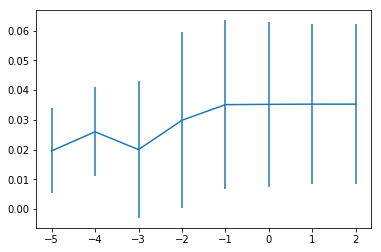

In [35]:
test_fds = []
for i in range(10):
    temp_fd = FairDataset(200, 5,
                          protected_attribute_names=['sex'],
                          privileged_classes=[['Male']],
                          random_state=i)
    test_fds.append(temp_fd)
    # print(temp_fd)
    
    
results = []
for i in range(len(lmods)):
    results.append([])
    for fd in test_fds:
        md, di, acc = get_classifier_metrics(lmods[i], fd,
                                             privileged_groups=privileged_groups,
                                             unprivileged_groups=unprivileged_groups)
               
        
        results[i] += [[abs(md), abs(1-di), acc]]
    
    # print(results[i])

    
results = np.array(results)
means = np.mean(results, axis=1)
variations = np.std(results, axis=1)
# print(results)
print(means)
print(variations)
plt.errorbar(np.log10(regularizers), means[:, 1], yerr=variations[:, 1])

### Bayes Model

In [36]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(fd_train_x, fd_train_y)

gnb_results = []
for fd in test_fds:
    gnb_results.append(get_classifier_metrics(gnb, fd, 
                                 privileged_groups, 
                                 unprivileged_groups))
    print(gnb_results[-1])

(-0.0025000000000000577, 0.9950980392156862, 0.85375)
(-0.010000000000000009, 0.9801980198019802, 0.8575)
(-0.0025000000000000022, 0.9948979591836735, 0.85875)
(0.010000000000000009, 1.0211640211640212, 0.87)
(0.04249999999999998, 1.0894736842105264, 0.85875)
(-0.012499999999999956, 0.9753694581280788, 0.86375)
(-0.007499999999999951, 0.9853658536585367, 0.88125)
(-0.02250000000000002, 0.955, 0.86875)
(0.04500000000000004, 1.09375, 0.855)
(0.0025000000000000022, 1.005128205128205, 0.84125)


In [37]:
print('Standard Deviation for Bayes classifier Disparate Impact:')
print(np.std([abs(1-tup[1])for tup in gnb_results]))
print(np.mean([abs(1-tup[1])for tup in gnb_results]))

Standard Deviation for Bayes classifier Disparate Impact:
0.03175844726805792
0.03235865805147973
